In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from paretoset import paretoset
import pickle

import pickle
import sys
sys.path.append('../')
sys.path.append('../usecase_cd')
sys.path.append('../src')
import src
import utils 

plt.style.use("seaborn-v0_8-paper")

font = 14
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'arial',
    'font.size': font,
    'axes.labelsize': font,  
    'xtick.labelsize': font,  
    'ytick.labelsize': font, 
    'legend.fontsize': font,
    'legend.title_fontsize': font,
    'axes.titlesize': font
})
import warnings
warnings.filterwarnings("ignore")

## Tutorial: Analysis of collected Pareto frontier 

This notebook serves as tutorial for analysing solutions for multiple-optimization objectives (=Pareto frontier).
1. We will look into how we can retrieve these solutions of a random 2D sample set.
2. We will investigate our smallest network topology, the (2,1)-tree.

### 1. Pareto front of a random 2D sample set 

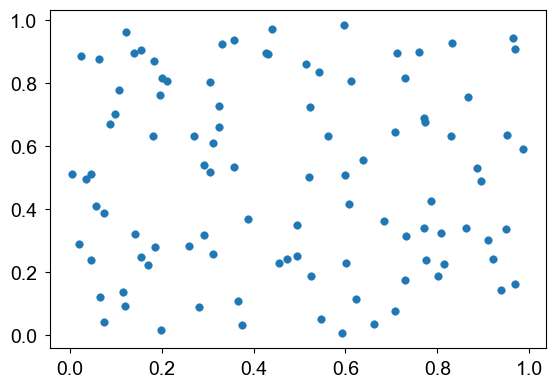

In [3]:
a = 0
b = 1
sample = (b-a) * np.random.random_sample((2,100)) + a
plt.scatter(x=sample[0], y=sample[1])
plt.show()

The Pareto frontier of the collected sample can be easiliy retrieved with `paretoset()` and is marked in orange below.

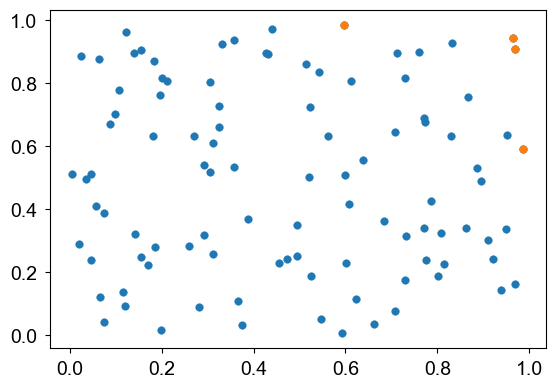

In [4]:
filter = paretoset(sample.T, sense=["max", "max"])

plt.scatter(x=sample[0], y=sample[1])
plt.scatter(x=sample[0][filter], y=sample[1][filter])
plt.show()

### 2. Pareto analysis of (2,1)-tree of collected solution set

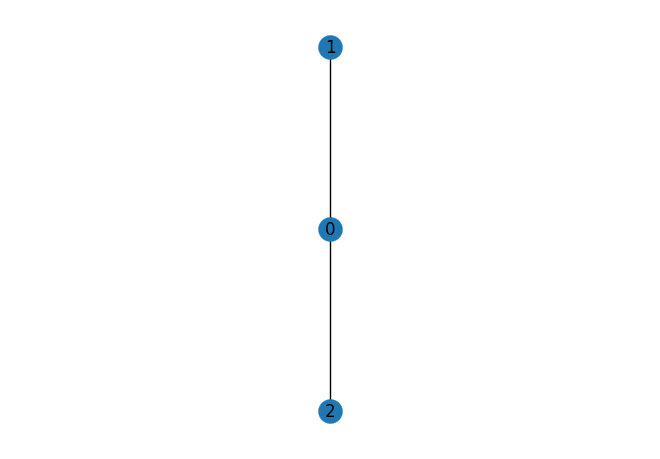

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

T = nx.balanced_tree(2, 1)

pos = graphviz_layout(T, prog="twopi")
nx.draw(T, pos, with_labels=True)
plt.show()

Load solution from `surdata` or run `sur.py --topo 2,1 --time 0.5` (30 min runtime). `config.py` is set with the following parameters

* 'protocol': 'ndsrs',
* 'p_gen': 0.9,
* 'p_swap': 1,
* 'return_data': 'avg',
* 'progress_bar': None,
* 'total_time': 1000,
* 'N_samples': 1000,
* 'p_cons': 0.225,
* 'qbits_per_channel': 5,
* 'cutoff': 28,
* 'M': 2,
* 'A': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]])

In [19]:
with open('../../surdata/SU_tree-2-1_20iterator_objective-meanopt_SEED42_04-23-2024_17:56:17.pkl', 'rb') as file: 
    # Load the object from the file
    sur_loaded_data = pickle.load(file)
model = sur_loaded_data

In [20]:
model.vals

{'protocol': 'ndsrs',
 'p_gen': 0.9,
 'p_swap': 1,
 'return_data': 'avg',
 'progress_bar': None,
 'total_time': 1000,
 'N_samples': 1000,
 'p_cons': 0.225,
 'qbits_per_channel': 5,
 'cutoff': 28,
 'M': 2,
 'A': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]])}

In [17]:
# How to calculate which cutoff time to set (given total runtime T, M, Fnew and Fapp)
T = 1000
M = 4
Fnew = 0.888
Fapp = 0.6
-T*np.log( 3/(4*Fnew-1) * ((4*Fapp-1)/3)**(1/M) )

28.800089826157972

In [18]:
virtual_neighbours = pd.DataFrame(model.y) # N = 1000
virtual_neighbours.columns = [f'node {i}' for i in range(3)]
virtual_neighbours = virtual_neighbours[['node 0', 'node 1', 'node 2']]
virtual_neighbours

,node 0,node 1,node 2
0,0.243243,1.123123,1.120120
1,0.978979,1.464464,1.470470
2,0.162162,1.085085,1.077077
3,0.380380,1.188188,1.190190
4,1.993994,1.302302,1.302302
...,...,...,...
185,1.879880,1.638639,1.636637
186,1.856857,1.612613,1.613614
187,1.850851,1.611612,1.610611
188,1.859860,1.630631,1.638639


In [10]:
vn = virtual_neighbours.to_numpy()
filter = paretoset(vn, sense=["max"]*3)

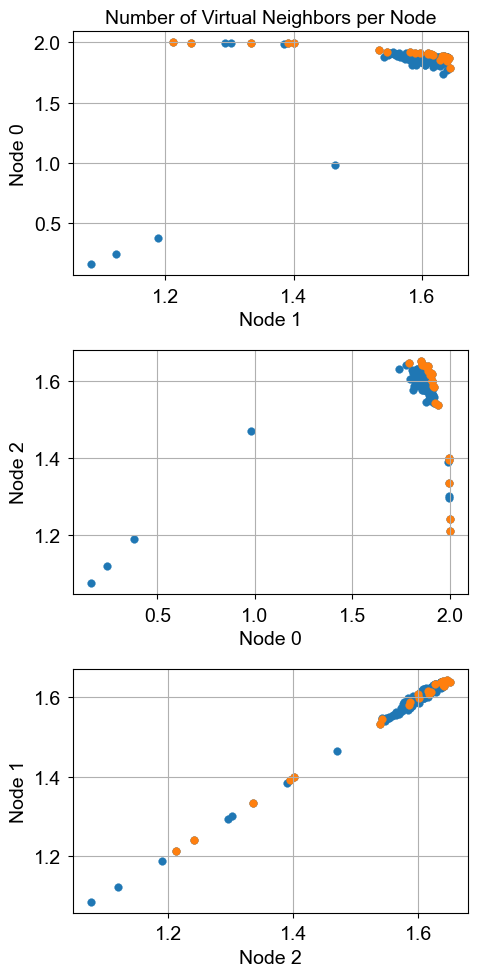

In [11]:
fig, axs = plt.subplots(3,sharey=False, sharex=False, figsize=[5,10])
labels = [1,0,2,1]
for i,ax in enumerate(axs):
    ax.scatter(x=vn[:,labels[i]], y=vn[:,labels[i+1]])
    ax.scatter(x=vn[:,labels[i]][filter], y=vn[:,labels[i+1]][filter])
    ax.set_xlabel(f'Node {labels[i]}')
    ax.set_ylabel(f'Node {labels[i+1]}')
    ax.grid()
axs[0].set_title('Number of Virtual Neighbors per Node')
plt.tight_layout()
plt.show()

In [12]:
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
virtual_neighbours['filter'] = filter
fig = px.scatter_3d(virtual_neighbours, x=virtual_neighbours.columns[0], y=virtual_neighbours.columns[1], z=virtual_neighbours.columns[2],
              color='filter')
plt.tight_layout()
fig.show()

<Figure size 640x440 with 0 Axes>

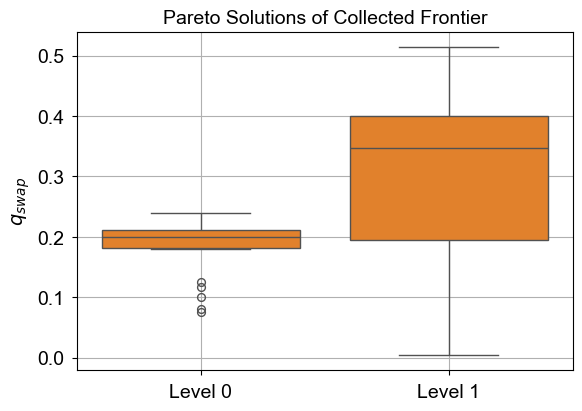

In [13]:
fig, ax = plt.subplots()
g = sns.boxplot(model.X_df[filter].drop(['Iteration'], axis=1), palette=['tab:orange'])
g.set_xticklabels(['Level 0', 'Level 1'])
plt.ylabel(r'$q_{swap}$')
plt.title('Pareto Solutions of Collected Frontier')
plt.grid()
plt.show()

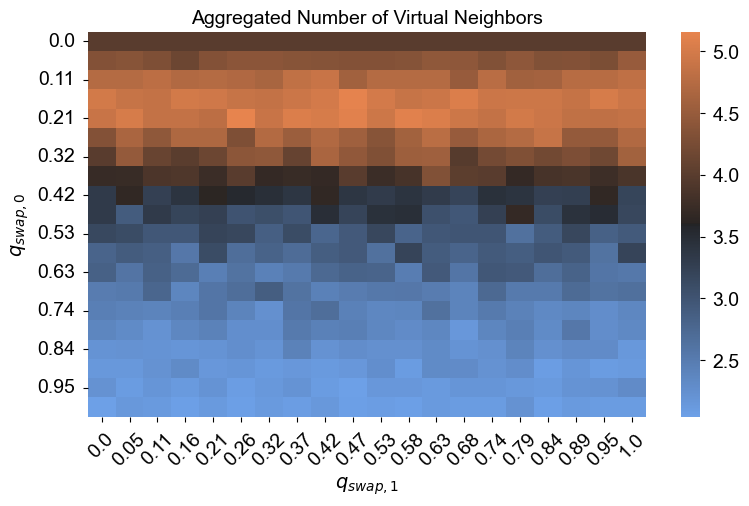

In [14]:
df_plot = pd.read_pickle('../usecase_cd/21tree-heatmap.pkl')
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(df_plot, cmap=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)) #cbar_kws={'label': 'Aggregated Virtual Neighbors'}
plt.xlabel(r'$q_{swap,1}$')
plt.ylabel(r'$q_{swap,0}$')
plt.yticks(rotation=0) 
plt.xticks(rotation=45) 
plt.title('Aggregated Number of Virtual Neighbors')
plt.show()

<div style="max-width:400px;margin-left: auto; margin-right: 0

In [71]:
df_plot

q_swap_level1,0.00,0.05,0.11,0.16,0.21,0.26,0.32,0.37,0.42,0.47,0.53,0.58,0.63,0.68,0.74,0.79,0.84,0.89,0.95,1.00
q_swap_level0,,,,,,,,,,,,,,,,,,,,
0.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00
0.05,4.34,4.38,4.30,4.16,4.34,4.40,4.40,4.38,4.36,4.34,4.34,4.36,4.44,4.42,4.32,4.42,4.32,4.34,4.28,4.50
0.11,4.74,4.74,4.80,4.72,4.74,4.70,4.64,4.84,4.90,4.58,4.74,4.74,4.74,4.50,4.78,4.58,4.60,4.76,4.76,4.82
0.16,4.98,4.88,4.86,4.98,4.96,4.88,4.86,4.92,5.00,5.14,5.00,4.89,4.92,5.06,4.92,4.94,4.93,4.87,5.02,4.92
0.21,4.90,5.02,4.86,4.86,4.80,5.16,4.90,5.06,5.02,5.10,4.94,5.10,5.06,4.94,4.86,4.98,4.92,4.84,4.82,4.86
0.26,4.34,4.65,4.43,4.69,4.69,4.30,4.73,4.53,4.71,4.57,4.37,4.59,4.79,4.49,4.67,4.74,4.88,4.47,4.47,4.71
0.32,3.99,4.47,4.12,4.01,4.15,4.41,4.43,4.10,4.65,4.45,4.31,4.55,4.57,3.97,4.21,4.31,4.20,4.29,4.18,4.59
0.37,3.71,3.73,3.89,3.91,3.75,4.00,3.69,3.73,3.69,3.99,3.75,3.85,4.33,4.02,3.99,3.69,3.85,3.87,3.77,3.87
0.42,3.33,3.67,3.25,3.41,3.63,3.55,3.47,3.39,3.67,3.39,3.31,3.41,3.31,3.21,3.45,3.41,3.25,3.27,3.67,3.19
